In [1]:
import numpy as np
import cv2 as cv
 
img = cv.imread('./images/example-image.jpg')
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
 
sift = cv.SIFT_create()
keypoints = sift.detect(gray,None)
 
output_image = cv.drawKeypoints(
    img,
    keypoints,
    None,
    flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

cv.imshow('SIFT Keypoints', output_image)
cv.waitKey(0)
cv.destroyAllWindows()

# Print default parameters
print("nfeatures:", sift.getNFeatures())
print("nOctaveLayers:", sift.getNOctaveLayers())
print("contrastThreshold:", sift.getContrastThreshold())
print("edgeThreshold:", sift.getEdgeThreshold())
print("sigma:", sift.getSigma())

for i, kp in enumerate(keypoints[:10]): 
    print(f"{i}: pt={kp.pt}, size={kp.size}, angle={kp.angle}")

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in ""


nfeatures: 0
nOctaveLayers: 3
contrastThreshold: 0.04
edgeThreshold: 10.0
sigma: 1.6
0: pt=(25.056865692138672, 96.4741439819336), size=22.15937614440918, angle=29.369735717773438
1: pt=(25.056865692138672, 96.4741439819336), size=22.15937614440918, angle=96.75642395019531
2: pt=(25.056865692138672, 96.4741439819336), size=22.15937614440918, angle=247.10455322265625
3: pt=(28.548383712768555, 385.4710998535156), size=20.997682571411133, angle=256.58172607421875
4: pt=(29.529165267944336, 65.21955108642578), size=12.45711898803711, angle=170.64370727539062
5: pt=(44.78803253173828, 351.18353271484375), size=24.00809669494629, angle=185.05189514160156
6: pt=(44.78803253173828, 351.18353271484375), size=24.00809669494629, angle=249.26431274414062
7: pt=(55.40457534790039, 139.0179443359375), size=9.305007934570312, angle=285.09259033203125
8: pt=(57.89128494262695, 411.7364501953125), size=52.30194091796875, angle=356.9489440917969
9: pt=(71.68193817138672, 101.66063690185547), size=38.29

In [2]:
sift_tuned = cv.SIFT_create(
    contrastThreshold=0.08,
    edgeThreshold=5,
    sigma=1.2
)

keypoints_tuned = sift_tuned.detect(gray, None)

output_image_tuned = cv.drawKeypoints(
    img,
    keypoints_tuned,
    None,
    flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

cv.imshow('SIFT Keypoints (Tuned Parameters)', output_image_tuned)
cv.waitKey(0)
cv.destroyAllWindows()

In [5]:
kps = sift_tuned.detect(gray, None)
kps, descs = sift.compute(gray, kps)

print(f"# keypoints: {len(kps)}  | descriptor shape: {descs.shape}")  # (N, 128)

# keypoints: 175  | descriptor shape: (175, 128)


In [7]:
# Pick the strongest keypoint
idx = int(np.argmax([kp.size for kp in kps]))
kp = kps[idx]
d = descs[idx]

# Square size slightliy larger than keypoint size
side = 1.01 * kp.size
center = kp.pt
angle = kp.angle  # degrees

# Get the oriented square patch corners
box = cv.boxPoints(((center[0], center[1]), (side, side), angle))
box = np.int32(box)

img_vis = img.copy()
# Draw the keypoint center and oriented box
cv.circle(img_vis, (int(center[0]), int(center[1])), 2, (0, 255, 0), -1)
cv.polylines(img_vis, [box], isClosed=True, color=(0, 255, 255), thickness=2)

# Also draw the rich keypoint (scale+orientation)
img_kp = cv.drawKeypoints(img_vis, [kp], None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv.imshow('Selected Keypoint + Oriented Patch', img_kp)
cv.waitKey(0); cv.destroyAllWindows()


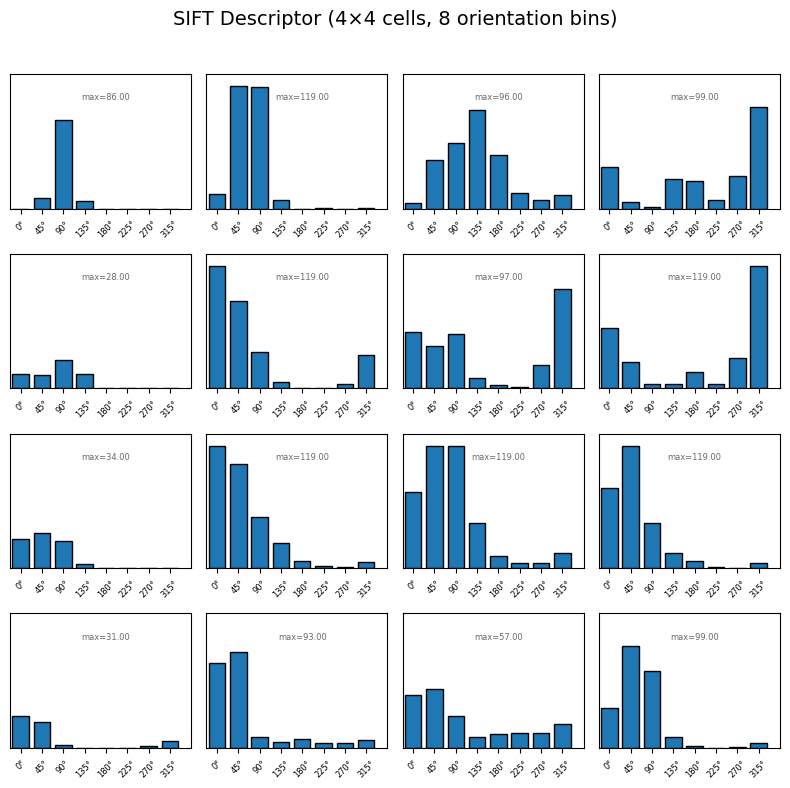

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Reshape 128 -> (4,4,8)
grid = d.reshape(4, 4, 8)

# Define orientation bin centers (in degrees)
bin_centers = np.arange(0, 360, 45)  # 8 bins

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('SIFT Descriptor (4×4 cells, 8 orientation bins)', fontsize=14)

for i in range(4):
    for j in range(4):
        # Extract histogram for this cell
        hist = grid[i, j]
        # Orientation bins in degrees
        axes[i, j].bar(bin_centers, hist, width=35, align='center', edgecolor='black')
        axes[i, j].set_xlim(-22.5, 360)
        axes[i, j].set_xticks(bin_centers)
        axes[i, j].set_xticklabels(['0°', '45°', '90°', '135°', '180°', '225°', '270°', '315°'],
                                   fontsize=6, rotation=45)
        axes[i, j].set_yticks([])
        axes[i, j].set_ylim(0, grid.max() * 1.1)
        # Add magnitude label
        axes[i, j].text(180, grid.max() * 0.95,
                        f"max={hist.max():.2f}",
                        ha='center', va='top', fontsize=6, color='dimgray')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
